# Analyse exploratoire des données  
## Projet Data Engineer — Challenge Artefact

Ce notebook présente l’analyse exploratoire d’un jeu de données représentant les ventes d’un site e-commerce.  
Notre objectif est de comprendre la structure des données, d’identifier les entités métier, d’évaluer la qualité des données et de préparer une modélisation relationnelle normalisée en vue de leur ingestion dans une base PostgreSQL.


## 1. Contexte et objectifs

Cette analyse exploratoire constitue la première étape du projet.  
Elle vise à :

- Comprendre la granularité réelle des données
- Identifier les entités métier principales
- Évaluer la qualité et la cohérence des données
- Mettre en évidence d’éventuelles anomalies ou limites
- Préparer les choix de modélisation (3FN / DKNF)

Notre analyse est conduite dans une logique proche d’un contexte de mission client, où la clarté, la justification des choix et la réutilisabilité priment.


## 2. Importation des packages nécessaires 

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10,6)

## 3. Chargement du jeu de données

Le fichier source correspond à un export des ventes d’un site e-commerce.  
Il est considéré comme une **source brute** et n’est pas modifié manuellement.


In [2]:
def load_csv(path: str) -> pd.DataFrame:
    return pd.read_csv(path)

In [3]:
path = "D:/Artefact CI_ Data Engineer/Projet_artefact/data/source/fashion_store_sales _ Data Eng.csv"
df = load_csv(path)
df.head()

,sale_date,item_id,sale_id,product_id,quantity,original_price,unit_price,discount_applied,discount_percent,discounted,...,catalog_price,cost_price,customer_id,gender,age_range,signup_date,first_name,last_name,email,country
0,2025-06-16,2270,658,403,1,81.80,81.80,0.0,0.00%,0,...,81.80,45.12,835,Female,46-55,2025-04-26,Dusty,Comerford,dcomerfordn6@google.nl,Portugal
1,2025-06-17,1170,336,284,1,81.79,81.79,0.0,0.00%,0,...,81.79,35.02,790,Female,16-25,2025-04-26,Beale,Seeds,bseedslx@phpbb.com,France
2,2025-04-16,2496,1255,71,1,80.76,80.76,0.0,0.00%,0,...,80.76,51.01,464,Female,36-45,2025-04-14,Juan,Blacklock,jblacklockcv@discuz.net,Germany
3,2025-05-06,1273,331,98,1,78.52,78.52,0.0,0.00%,0,...,78.52,41.48,100,Female,26-35,2025-01-30,Godfry,Cockerill,gcockerill2r@vimeo.com,Italy
4,2025-06-15,1829,1079,98,1,78.52,78.52,0.0,0.00%,0,...,78.52,41.48,837,Female,46-55,2025-03-02,NaN,Kilby,lkilbyn8@wordpress.com,Germany


## 4. Dimensions du dataset

Nous analysons dans un premier temps les dimensions globales du dataset afin d’évaluer son volume et sa complexité.


In [4]:
df.shape


(2253, 29)

Le dataset contient **2 253 lignes** et **29 colonnes**.  
Chaque ligne correspond à un enregistrement transactionnel issu du système de vente.


## 5. Liste des colonnes

Nous listons ci-dessous l’ensemble des colonnes présentes dans le fichier source.


In [5]:
df.columns.tolist()


['sale_date',
 'item_id',
 'sale_id',
 'product_id',
 'quantity',
 'original_price',
 'unit_price',
 'discount_applied',
 'discount_percent',
 'discounted',
 'item_total',
 'channel',
 'channel_campaigns',
 'total_amount',
 'product_name',
 'category',
 'brand',
 'color',
 'size',
 'catalog_price',
 'cost_price',
 'customer_id',
 'gender',
 'age_range',
 'signup_date',
 'first_name',
 'last_name',
 'email',
 'country']

## 6. Description fonctionnelle des données

Après l’identification des colonnes, il est nécessaire de leur donner une lecture **fonctionnelle et métier**.  
Plutôt qu’une description colonne par colonne, les champs sont regroupés par **entités métier**, afin de préparer la modélisation relationnelle et faciliter la compréhension globale du dataset.


###  Vente

Cette entité représente l’acte de vente global.

- `sale_id` : identifiant unique de la vente
- `sale_date` : date de réalisation de la vente
- `channel` : canal de vente (ex :E-commerce,App Mobile)
- `channel_campaigns` : campagne marketing associée à la vente
- `total_amount` : montant total agrégé de la vente

---

###  Ligne de vente

Cette entité correspond au détail des produits vendus au sein d’une vente.

- `item_id` : identifiant de la ligne de vente
- `quantity` : quantité vendue
- `unit_price` : prix unitaire après application des remises
- `item_total` : montant total de la ligne de vente
- `discounted` : indicateur précisant si une remise a été appliquée (0: pour pas de remise, 1: pour remise)
- `discount_applied` : montant de la remise
- `discount_percent` : pourcentage de remise
- `original_price` : prix initial avant remise

---

###  Produit

Cette entité décrit les caractéristiques des produits vendus.

- `product_id` : identifiant du produit
- `product_name` : nom du produit
- `category` : catégorie du produit
- `brand` : marque du produit
- `color` : couleur
- `size` : taille
- `catalog_price` : prix catalogue
- `cost_price` : prix de revient du produit

---

###  Client

Cette entité regroupe les informations relatives aux clients.

- `customer_id` : identifiant unique du client
- `gender` : genre
- `age_range` : tranche d’âge
- `country` : pays
- `signup_date` : date d’inscription
- `first_name` : prénom
- `last_name` : nom
- `email` : adresse email

---

### Dimensions métier complémentaires

Certaines informations, telles que le canal de vente et la campagne marketing,
constituent des dimensions transverses aux ventes.

Elles seront analysées ultérieurement afin de déterminer si leur séparation
dans des entités dédiées est pertinente au regard de la normalisation et de
l’évolutivité du modèle.



Cette description fonctionnelle nous permet de :

- Clarifier le rôle de chaque champ.
- Identifier et mettre en évidence les **entités métier** sous-jacentes (vente, produit, ligne de vente et client).
- Constituer une base solide pour l'analyse de la qualité des données et la future modélisation relationnelle.


## 7. Typage des données

L’analyse des types nous permettra d’identifier :
- les identifiants
- les montants financiers
- les variables catégorielles
- les dates à convertir


In [6]:
df.dtypes

sale_date             object
item_id                int64
sale_id                int64
product_id             int64
quantity               int64
original_price       float64
unit_price           float64
discount_applied     float64
discount_percent      object
discounted             int64
item_total           float64
channel               object
channel_campaigns     object
total_amount         float64
product_name          object
category              object
brand                 object
color                 object
size                  object
catalog_price        float64
cost_price           float64
customer_id            int64
gender                object
age_range             object
signup_date           object
first_name            object
last_name             object
email                 object
country               object
dtype: object

On observe que :
- les dates (`sale_date`, `signup_date`) sont stockées sous forme de chaînes
- les montants financiers (`item_total`,`cost_price` ,...) sont stockés en `float`
- les identifiants(`item_id` ,`sale_id` , `product_id`, `customer_id` ) sont numériques

Les conversions de type seront réalisées lors de l’ingestion.


## 8. Analyse des valeurs manquantes

Nous évaluons la complétude des données afin d’identifier les champs critiques et les champs optionnels.


In [7]:
def missing_values_summary(df: pd.DataFrame) -> pd.DataFrame:
    
    return (df.isnull().sum().to_frame("missing_count")
        .assign(missing_pct=lambda x: x["missing_count"] / len(df) * 100)
        .sort_values("missing_count", ascending=False)
    )

In [8]:
missing_values_summary(df)

,missing_count,missing_pct
total_amount,225,9.986684
email,224,9.942299
first_name,116,5.148691
last_name,64,2.840657
sale_date,0,0.000000
category,0,0.000000
signup_date,0,0.000000
age_range,0,0.000000
gender,0,0.000000
customer_id,0,0.000000


Les champs transactionnels critiques ne présentent pas de valeurs manquantes.  
En revanche, certaines informations personnelles clients (`first_name`, `last_name`, `email`) sont partiellement manquantes.

Ces champs ne peuvent donc pas être utilisés comme clés métier fiables.

La stratégie que nous avons retenue est :
- La conservation des valeurs manquantes lors de l’ingestion
- Les champs définis comme optionnels dans le modèle
- Le traitements spécifiques possibles ultérieurement selon les besoins métier


## 9. Analyse des doublons et règles d’unicité métier

Ici , nous analysons les doublons selon les règles métier et non uniquement
sur des lignes strictement identiques.


In [9]:
def check_unicite(df: pd.DataFrame, keys: list) -> int:
    
    return df.duplicated(subset=keys).sum()

In [10]:
check_unicite(df, ["sale_id", "item_id"])

0

Aucune duplication n’a été détectée sur la combinaison `(sale_id, item_id)`.
Chaque ligne de vente est donc unique.


### Cohérence des ventes


In [11]:
df.groupby("sale_id")["sale_date"].nunique().describe()

count    905.0
mean       1.0
std        0.0
min        1.0
25%        1.0
50%        1.0
75%        1.0
max        1.0
Name: sale_date, dtype: float64

Chaque vente est associée à une seule date, ce qui confirme la cohérence temporelle des transactions.


## 10. Granularité réelle des données


In [12]:
df["sale_id"].nunique(), df["item_id"].nunique()

(905, 2253)

L’analyse des identifiants montre que :
- le dataset contient 905 ventes distinctes (`sale_id`)
- chaque ligne correspond à un item vendu (`item_id` unique par ligne)

La granularité réelle des données est donc la ligne de vente.Une vente peut contenir plusieurs items,ce qui correspond à une relation 1-N entre ventes et lignes de vente.


In [13]:
df.groupby("sale_id")["item_id"].count().describe()


count    905.000000
mean       2.489503
std        0.500166
min        2.000000
25%        2.000000
50%        2.000000
75%        3.000000
max        3.000000
Name: item_id, dtype: float64

Cette analyse de la distribution du nombre d’items par vente montre que :
- chaque vente contient entre 2 et 3 items
- la majorité des ventes contient 2 items




## 11. Analyse des entités métier et dépendances fonctionnelles

### 11.1 Entité Produit

In [15]:
df.groupby("product_id")[["product_name", "category", "brand"]].nunique().max()

product_name    1
category        1
brand           1
dtype: int64

Les attributs descriptifs du produit présentent une valeur unique par identifiant produit.
Cela confirme que ces attributs sont fonctionnellement dépendants de `product_id`.


Cette observation justifie la création d’une entité produit dédiée dans le modèle de données.

### 11.2 Entité Client

In [16]:
df.groupby("customer_id")[["email"]].nunique().max()

email    1
dtype: int64

Les informations client ont été analysées afin de vérifier leur stabilité par
identifiant client.

Une attention particulière a été portée au champ `email`, un client pouvant
théoriquement disposer de plusieurs adresses électroniques.

L’analyse montre qu’une seule adresse email est associée à chaque
`customer_id`, ce qui confirme la stabilité des attributs client dans notre dataset analysé.

Cette observation permet de considérer l’ensemble des informations client
comme fonctionnellement dépendantes de l’identifiant client, et justifie leur
regroupement au sein d’une entité client unique dans le modèle de données.


### 11.3 Entité Channel 

In [ ]:
df["channel"].value_counts()

channel
E-commerce    1170
App Mobile    1083
Name: count, dtype: int64

L’analyse du champ `channel` met en évidence deux canaux de vente principaux :
E-commerce et Application mobile, avec une répartition relativement équilibrée
des ventes.

Aussi, la faible cardinalité et la stabilité des valeurs observées indiquent que le
canal de vente constitue une dimension métier de référence.

Cette caractéristique justifie la séparation de cette information dans une
entité dédiée lors de la modélisation, afin de :
- limiter la redondance des valeurs
- faciliter l’évolution future des canaux
- garantir la cohérence des données sur l’ensemble des ventes


### 11.4 Analyse du champ `channel_campaigns`


In [20]:
df["channel_campaigns"].value_counts(dropna=False)

channel_campaigns
Website Banner    1151
App Mobile         963
Social Media       120
Email               19
Name: count, dtype: int64

#### Graphique des répartitions des ventes par campagne

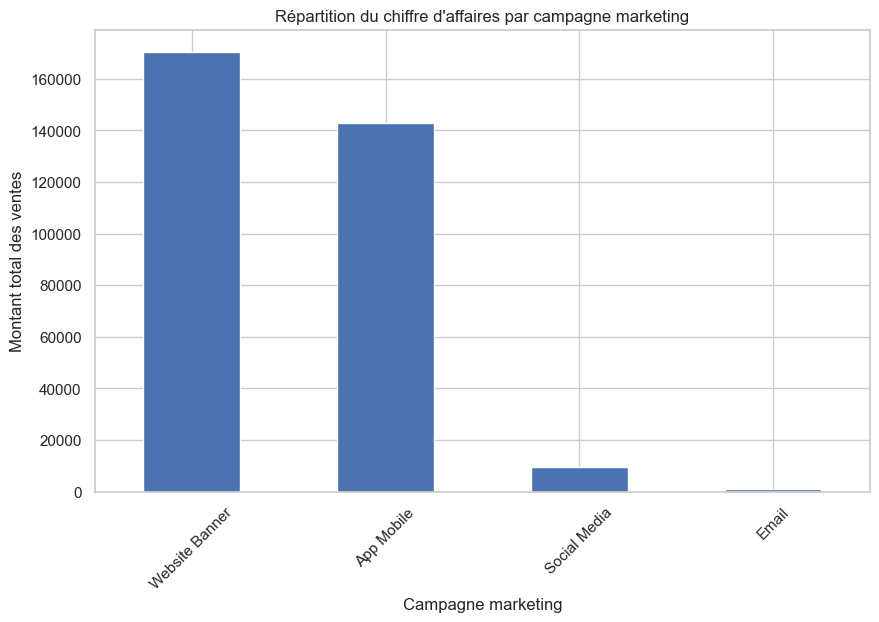

In [23]:
campaign_sales = (
    df.groupby("channel_campaigns")["item_total"]
    .sum()
    .sort_values(ascending=False)
)

campaign_sales.plot(kind="bar")
plt.title("Répartition du chiffre d'affaires par campagne marketing")
plt.xlabel("Campagne marketing")
plt.ylabel("Montant total des ventes")
plt.xticks(rotation=45)
plt.show()


Ce graphique montre que les campagnes marketing n’ont pas toutes le même impact
sur le chiffre d’affaires.

On observe que certaines campagnes, comme *Website Banner* et *App Mobile*,
concentrent une grande partie des ventes, tandis que d’autres, comme
*Social Media* ou *Email*, génèrent un volume plus faible.

Cela confirme que la campagne est un critère important pour analyser les ventes.
Cependant, son importance peut évoluer dans le temps, avec l’apparition de
nouvelles campagnes ou la disparition d’anciennes.

Pour cette raison, il est préférable de gérer l’information « campagne »
séparément des ventes, afin de garder un modèle simple et évolutif.


## 12. Analyse de cohérence des montants des lignes de vente


In [25]:
def check_amount_consistency(df: pd.DataFrame):

    df["correct_total"] = df["quantity"] * df["unit_price"]
    
    df["difference"] = df["item_total"] - df["correct_total"]

    inconsistent_rows = df[df["difference"] != 0].copy()

    num_inconsistent = inconsistent_rows.shape[0]
    
    inconsistent_rows = inconsistent_rows[[
        "quantity", "unit_price", "item_total", "correct_total", "difference"
    ]]
    
    return num_inconsistent, inconsistent_rows



In [26]:
num, rows = check_amount_consistency(df)
print(f"{num} écarts identifiés.")
print(rows.head())  



346 écarts identifiés.
     quantity  unit_price  item_total  correct_total  difference
545         2       58.73      117.47         117.46        0.01
674         2       49.55       99.11          99.10        0.01
707         2       46.89       93.79          93.78        0.01
708         2       46.89       93.79          93.78        0.01
711         2       46.56       93.13          93.12        0.01


#### Graphique de la distribution des écarts de montants des lignes de vente

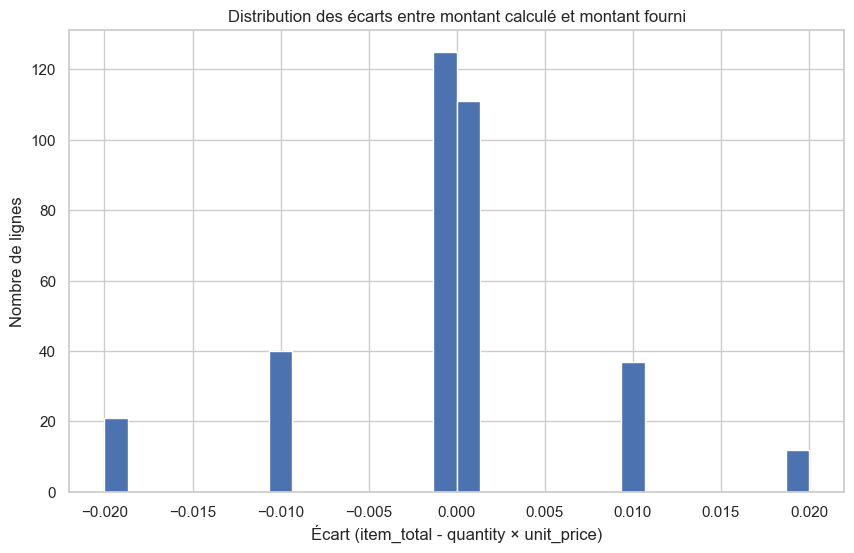

In [27]:
plt.hist(rows["difference"], bins=30)
plt.title("Distribution des écarts entre montant calculé et montant fourni")
plt.xlabel("Écart (item_total - quantity × unit_price)")
plt.ylabel("Nombre de lignes")
plt.show()


La distribution des écarts montre que la majorité des différences sont très proches de zéro.

Ces écarts sont typiques des erreurs de représentation des nombres flottants et ne traduisent pas de réelles incohérences métier.

Toutefois , nous pourrons recalculer les montants lors de l’ingestion afin de garantir une cohérence financière parfaite

## 13.Analyse de la cohérence des montants du total des ventes.

Au niveau d’une vente, le montant total (`total_amount`) doit correspondre
à la somme des montants des items qui la composent.

Cette vérification permettra de détecter d’éventuelles incohérences
entre les niveaux ligne et transaction.


In [ ]:
def check_sale_total_consistency(df: pd.DataFrame) -> pd.DataFrame:
    
    aggregated = (
        df.groupby("sale_id")
        .agg(
            calculated_total=("item_total", "sum"),
            reported_total=("total_amount", "first")
        )
        .reset_index())

    aggregated["difference"] = (
        aggregated["reported_total"] - aggregated["calculated_total"])

    return aggregated[aggregated["difference"] != 0]


### Nombre de ventes incoherentes

In [31]:
sale_total_issues = check_sale_total_consistency(df)
sale_total_issues.shape[0]


183

### Mise en évidence du caractère numérique des écarts

In [32]:
sale_total_issues["difference"].abs().describe()


count    1.810000e+02
mean     5.276074e-14
std      2.566407e-14
min      1.421085e-14
25%      2.842171e-14
50%      5.684342e-14
75%      5.684342e-14
max      1.136868e-13
Name: difference, dtype: float64

#### Graphique de la distribution des écarts entre le total des ventes declaré et calculé

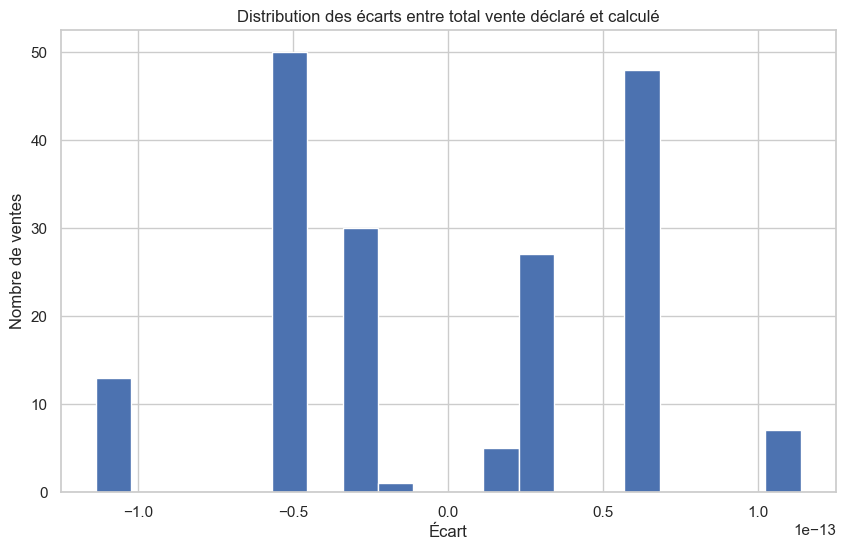

In [33]:
plt.hist(sale_total_issues["difference"], bins=20)
plt.title("Distribution des écarts entre total vente déclaré et calculé")
plt.xlabel("Écart")
plt.ylabel("Nombre de ventes")
plt.show()


Les écarts observés au niveau du total de vente sont extrêmement faibles (ordre de grandeur 10⁻¹⁴).

Ces différences correspondent à des erreurs numériques liés aux calculs en virgule flottante et non à des incohérences financières réelles.

D’un point de vue métier, les montants sont donc cohérents.

## 14. Cohérence des prix et des remises

Cette analyse vise à vérifier la logique commerciale des prix appliqués,
en particulier :
- la cohérence entre prix catalogue, prix unitaire et remise
- l’absence de prix aberrants


In [ ]:
def check_price_consistency(df: pd.DataFrame) -> pd.DataFrame:
    
    return df[df["unit_price"] > df["catalog_price"]]


In [29]:
price_issues = check_price_consistency(df)
price_issues.shape[0]


0

Aucune ligne de vente ne présente un prix unitaire supérieur au prix catalogue.

Ce résultat confirme la cohérence des règles de tarification appliquées
et l’absence d’anomalies de surfacturation dans notre jeu de données.


## 15. Cohérence temporelle

 Nous effectuons une vérification temporelle afin de s’assurer que :
- la date de vente est postérieure à la date d’inscription du client
 

In [35]:
def check_temporal_consistency(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df["sale_date"] = pd.to_datetime(df["sale_date"])
    df["signup_date"] = pd.to_datetime(df["signup_date"])

    return df[df["sale_date"] < df["signup_date"]]


### Nombre de dates incoherentes

In [36]:
temporal_issues = check_temporal_consistency(df)
temporal_issues.shape[0]


185

### Mise en évidence des écarts entre les deux dates 

In [37]:
( temporal_issues["sale_date"] - temporal_issues["signup_date"]).describe()


count                             185
mean     -19 days +11:17:11.351351352
std        13 days 15:26:27.894448661
min                -62 days +00:00:00
25%                -28 days +00:00:00
50%                -17 days +00:00:00
75%                 -6 days +00:00:00
max                 -1 days +00:00:00
dtype: object

#### Graphique de la distribution des écarts temporels

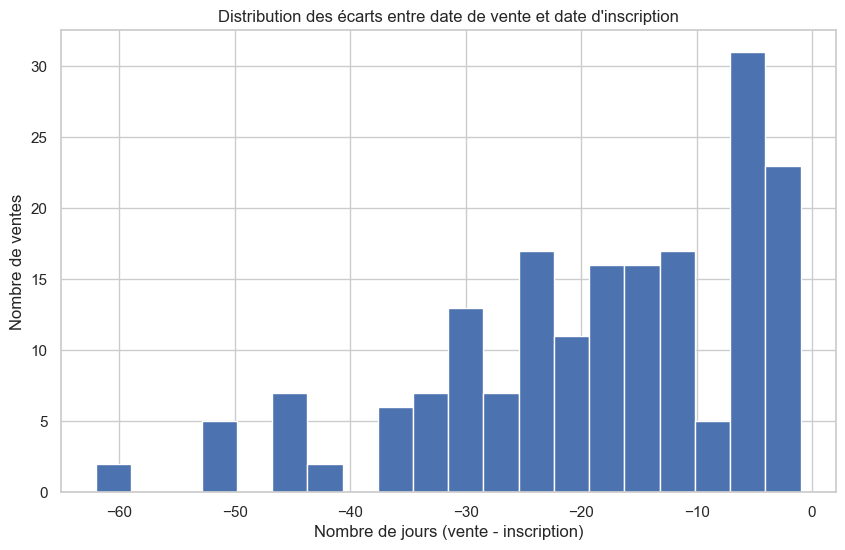

In [38]:
(
    (temporal_issues["sale_date"] - temporal_issues["signup_date"])
    .dt.days
    .plot(kind="hist", bins=20)
)

plt.title("Distribution des écarts entre date de vente et date d'inscription")
plt.xlabel("Nombre de jours (vente - inscription)")
plt.ylabel("Nombre de ventes")
plt.show()


La distribution des écarts temporels montre un comportement structuré, avec des écarts compris entre 1 et 62 jours.

Cette distribution suggère que la date d’inscription ne correspond pas nécessairement à la première interaction du client avec l’enseigne, mais plutôt à un événement ultérieur (création de compte, adhésion).

Ces observations ne traduisent pas une anomalie transactionnelle mais une
ambiguïté sémantique nécessitant une clarification métier.


## 16.Qualité globale des données

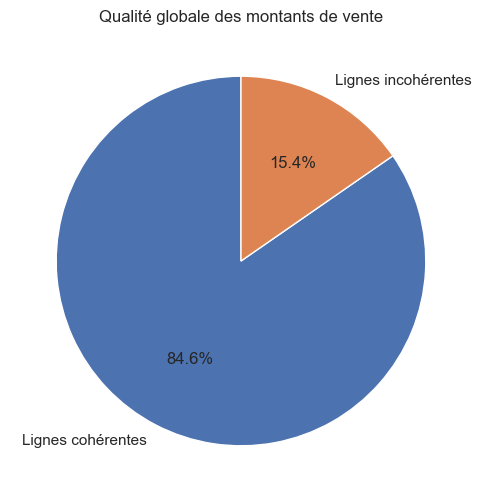

In [40]:
labels = ["Lignes cohérentes", "Lignes incohérentes"]
values = [
    (df["difference"] == 0).sum(),
    (df["difference"] != 0).sum()
]

plt.pie(values, labels=labels, autopct="%1.1f%%", startangle=90)
plt.title("Qualité globale des montants de vente")
plt.show()


Ce graphique fournit une vue synthétique de la qualité des données financières.

La majorité des lignes ( 84,6% ) sont cohérentes, et les écarts identifiés sont principalement techniques, cela confirme la fiabilité globale de notre jeu de données pour une ingestion en base analytique .

## 17. Bilan de l’analyse des données

L’analyse des données a permis de mieux comprendre leur contenu et leur structure.
Elle a notamment servi à :

- Identifier les principales informations disponibles (clients, produits, ventes).
- Comprendre comment les ventes sont enregistrées dans les données.
- Vérifier que les données sont globalement exploitables.

### Points de cohérence

Les contrôles effectués montrent que :

- Certains écarts de montants existent, mais ils restent limités et compréhensibles.
- Les prix appliqués aux produits suivent une logique cohérente.
- Les différences observées sur les dates sont souvent liées à leur signification
  (date de vente, date de traitement, etc.), plutôt qu’à de véritables erreurs.

Dans l’ensemble, les données sont suffisamment fiables pour être utilisées
dans la suite du projet.

---

## 18. Limites et impact pour le modèle

### Limites

Quelques limites ont été identifiées :

- Des incohérences ponctuelles sur certains montants.
- Des informations clients parfois manquantes.
- Certains champs texte (comme l’email) qui ne peuvent pas servir d’identifiant unique.

### Conséquences pour la suite du projet

Ces constats conduisent aux choix suivants :

- Utiliser les identifiants déjà présents dans les données pour relier les informations.
- Distinguer clairement les données de vente des données de référence
  (clients, produits).
- Mettre en place un modèle de données clair avant toute autre analyse .
